# Case study on auction for showing advertisement to random non-identifiable users

**Tasks:**
- Problem 1: For a given aggregated data set the expected win rate shall be estimated
- Problem 2: If the maximum budget of the advertisers would be 0.5, what would be the best bid valuation
    
**Steps:**
- Check the data and calculate the rates as amount of events with win divided by amount of wins
- Calculate max Win per bid_price and take into account the expected win rate
- Chose the best bid_price to maximize the win * expected win rate
- If there is a clear trend or tendency in the data, fit the win * expected win rate as function of bid_price, to be able to give best bid_prices with are not included in the underlying data

**Downfalls:**
- The data lacks a resonable discretization, it is not clear where the decay of the win * expected win rate occurs.
- Therefore, it is not really useful to fit to any function, here the weigthed linear fit shall only show the general idea

**Results:**
- Problem 1: see table below
- Problem 2: by the given data, the choice is a bid_price of 0.10, as it has the highest gain considering its expected win rate.
- Real application: Set up a dynamic approach, which tracts the expected and realized wins and modifies the strategy as competitors as well as budgets of competitors change and also there strategies. For fast reception and ability to counter changes, A/B-Test should be used to also bid on not optimal prices to estimate possible needed increases or possible decreases for more win extraction.

In [61]:
# Libraries
import numpy as np
import pandas as pd
#import scipy as sp
# for clopper pearson intervals
from statsmodels.stats.proportion import proportion_confint
# for 2. problem and weigthed linear regression
from sklearn.linear_model import LinearRegression


In [62]:
# Load data
data = pd.read_json('./data.json')

In [63]:
# group by for sum of all events and only wins per bid_price
aggDat = data.groupby('bid_price').apply(lambda s: pd.Series({
            'eventsAgg': s['events'].sum(),
            'eventsWinAgg': (s['events'] * s['win']).sum(),
        }
    )   
)

# group by for 1. problem expected win rate: expWinRate
aggDat['expWinRate'] = aggDat['eventsWinAgg'] / aggDat['eventsAgg']

# add some clopper pearson confidence bands
aggDat['confInt'] = aggDat.apply(
    lambda x: proportion_confint(
        int(
            x['eventsWinAgg']
        ),
        int(
            x['eventsAgg']
        ),
        alpha=0.05,
        method='normal'
    ),
    axis= 1,
)

# as confInt being a tuple, split it and round for better presentation
aggDat['lowerConfInt'] = (pd.DataFrame(aggDat['confInt'].tolist()).apply(lambda x : round(x,3))[0]).tolist()
aggDat['upperConfInt'] = (pd.DataFrame(aggDat['confInt'].tolist()).apply(lambda x : round(x,3))[1]).tolist()

del aggDat['confInt']

# add weights for later weigthed linear fit
aggDat['weight'] = aggDat['eventsAgg'] / aggDat['eventsAgg'].sum()

# get rid of index from grouping, as it will be needed as column
aggDat = aggDat.reset_index()

# add target for minimization
aggDat['win'] = 0.5 - aggDat['bid_price'] # possible win, if 0.5 is max budget 
aggDat['winProb'] = aggDat['win'] * aggDat['expWinRate'] # taking into account probabiltiy to win times win

aggDat.to_json('finalTable.json')

In [64]:
# 1. Problem: see bid_price vs expWinRate
aggDat
# 2. Problem: for discrete given bid_prices best valutation is 0.10 with the highest winProb and win of 0.40
# But, in real bidding the competors, there algorithms and budgets change, therefore a more dynamical approch must be utilized in real life

,bid_price,eventsAgg,eventsWinAgg,expWinRate,lowerConfInt,upperConfInt,weight,win,winProb
0,0.01,100000,0,0.0,0.000,0.000,8.911774e-03,0.49,0.000
1,0.10,10000,3000,0.3,0.291,0.309,8.911774e-04,0.40,0.120
2,0.20,10000000,2000000,0.2,0.200,0.200,8.911774e-01,0.30,0.060
3,0.40,1000000,300000,0.3,0.299,0.301,8.911774e-02,0.10,0.030
4,0.50,100000,20000,0.2,0.198,0.202,8.911774e-03,0.00,0.000
5,0.75,10000,3000,0.3,0.291,0.309,8.911774e-04,-0.25,-0.075
6,1.00,1000,600,0.6,0.570,0.630,8.911774e-05,-0.50,-0.300
7,2.00,100,70,0.7,0.610,0.790,8.911774e-06,-1.50,-1.050
8,5.00,10,8,0.8,0.552,1.000,8.911774e-07,-4.50,-3.600
9,9.00,1,1,1.0,1.000,1.000,8.911774e-08,-8.50,-8.500


<AxesSubplot:xlabel='bid_price'>

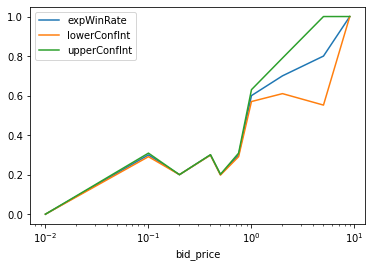

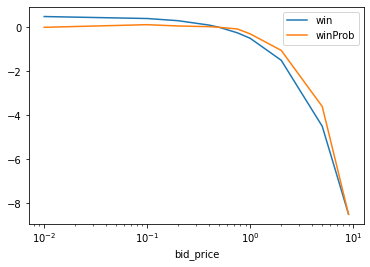

In [65]:
# plot, (lowerConfInt for bid_price 9 does not make sense - please ignore - not further corrected)
aggDat.plot(x = 'bid_price', y=['expWinRate','lowerConfInt','upperConfInt'], kind='line', logx = True)  
aggDat.plot(x = 'bid_price', y=['win','winProb'], kind='line',logx=True) 


Coef =  [[-0.13944029]]
Intercept =  [0.08672309]


<AxesSubplot:xlabel='bid_price'>

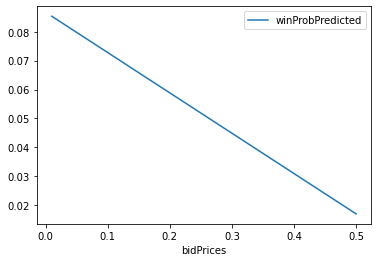

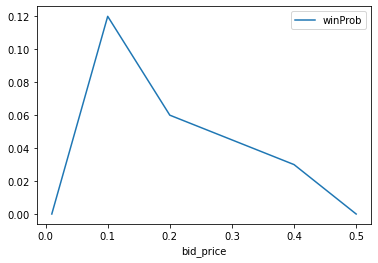

In [66]:
# 2. problem: task: fit winProb on bid_price - for possible interpolation for not given bid_prices
# the regression is of course not really useful, as we see in aggDat, that the fit will be dominated such, that a lower bid_price always ensures a higher win - the data is insufficent discretised and it is not clear, where the expWinRate starts to reduce below 0.1 as bid_price to assume a different polynominal fit 
reg = LinearRegression().fit(aggDat['bid_price'].to_numpy().reshape(-1, 1), aggDat['winProb'].to_numpy().reshape(-1, 1), aggDat['weight'])

print('Coef = ', reg.coef_)
print('Intercept = ', reg.intercept_)

bidPrices = np.linspace(0.01, 0.5, num=100)

predicts = pd.DataFrame({
    'bidPrices':  bidPrices,
    'winProbPredicted': reg.predict(bidPrices.reshape(-1, 1)).reshape(-1)
})


predicts.plot(x = 'bidPrices', y=['winProbPredicted'], kind='line') 
aggDat.iloc[0:5,].plot(x = 'bid_price', y=['winProb'], kind='line') 

